Best parameters for SVM (Phytoplankton): {'C': 10, 'kernel': 'rbf'}
Phytoplankton Classification Report:
              precision    recall  f1-score   support

    Level 10       0.82      0.97      0.89        33
     Level 2       0.57      1.00      0.73         8
     Level 3       0.77      0.82      0.79        33
     Level 4       0.98      0.97      0.98       283
     Level 5       0.98      0.90      0.94        52
     Level 6       1.00      0.95      0.98       108
     Level 7       0.96      0.63      0.76        71
     Level 8       0.40      0.40      0.40        43
     Level 9       0.74      0.95      0.83        80

    accuracy                           0.88       711
   macro avg       0.80      0.84      0.81       711
weighted avg       0.90      0.88      0.88       711

Phytoplankton Accuracy: 0.8846694796061885


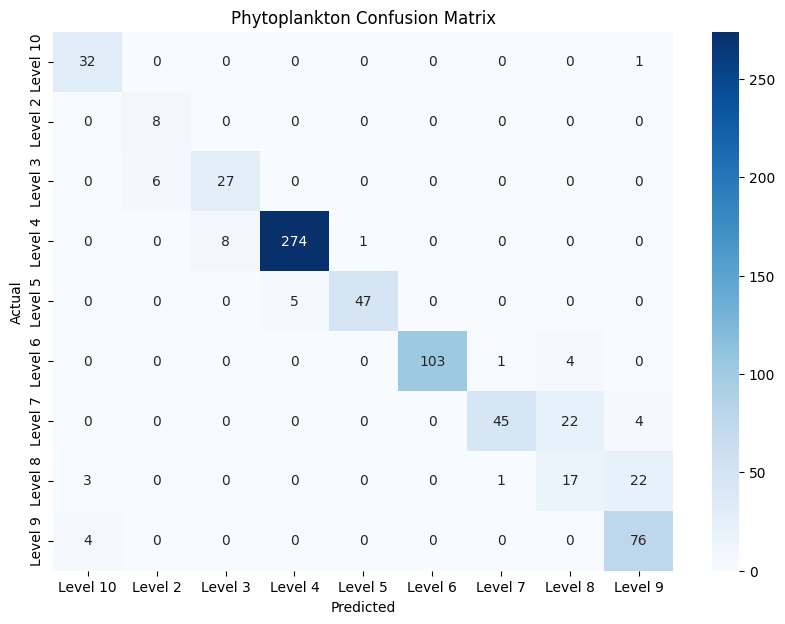

Best parameters for SVM (Zooplankton): {'C': 100, 'kernel': 'rbf'}
Zooplankton Classification Report:
              precision    recall  f1-score   support

    Level 10       1.00      1.00      1.00        12
     Level 2       1.00      1.00      1.00       133
     Level 3       0.97      0.90      0.93        31
     Level 4       0.96      0.90      0.93        77
     Level 5       0.58      0.90      0.70        50
     Level 6       0.87      0.60      0.71        57
     Level 7       0.96      0.83      0.89       164
     Level 8       0.84      0.96      0.90       122
     Level 9       0.97      1.00      0.98        65

    accuracy                           0.90       711
   macro avg       0.90      0.90      0.89       711
weighted avg       0.91      0.90      0.90       711

Zooplankton Accuracy: 0.8987341772151899


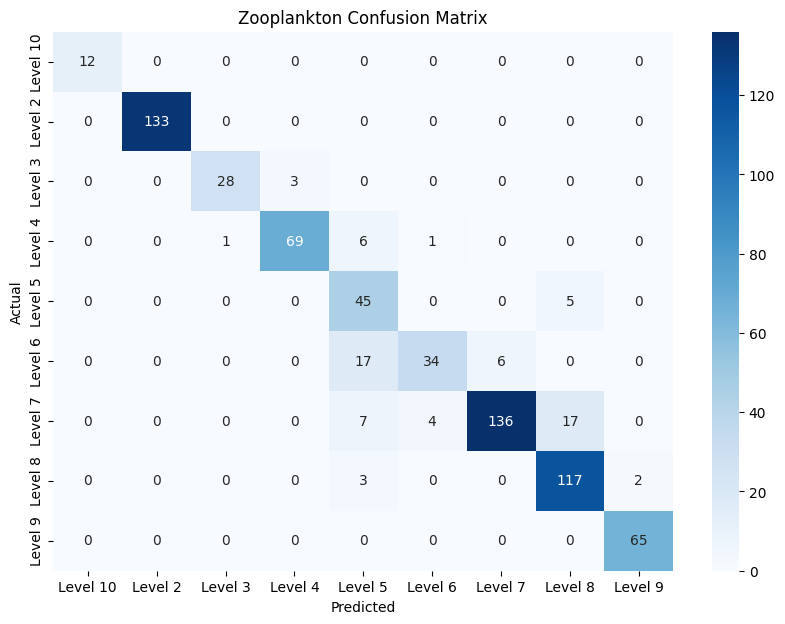

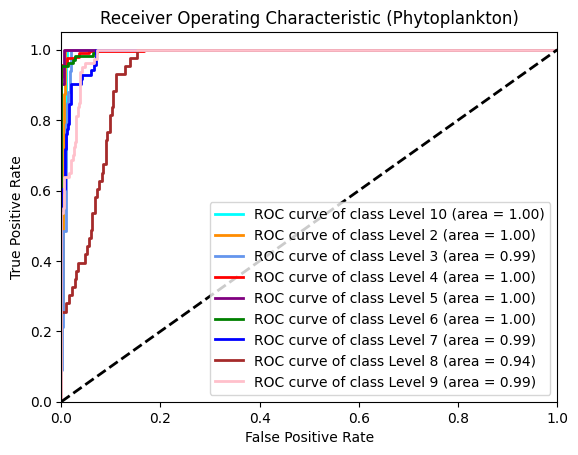

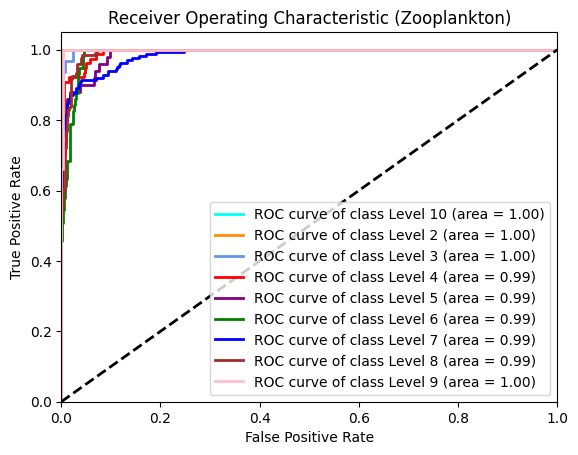

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle

# Load the dataset from the CSV file
df = pd.read_csv('3500leveling.csv')

# Features
X = df[['Temp', 'PH', 'TDS', 'Turbidity', 'DO']]

# Labels
y_phyto = df['Phytoplankton']
y_zoo = df['Zooplankton']

# Encode the labels
le_phyto = LabelEncoder()
le_zoo = LabelEncoder()
y_phyto_encoded = le_phyto.fit_transform(y_phyto)
y_zoo_encoded = le_zoo.fit_transform(y_zoo)

# Binarize the labels for ROC curve
y_phyto_binarized = label_binarize(y_phyto_encoded, classes=range(len(le_phyto.classes_)))
y_zoo_binarized = label_binarize(y_zoo_encoded, classes=range(len(le_zoo.classes_)))

# Split the data into training and testing sets
X_train, X_test, y_phyto_train, y_phyto_test, y_zoo_train, y_zoo_test = train_test_split(
    X, y_phyto_encoded, y_zoo_encoded, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the SVM classifier
svm = SVC(probability=True, random_state=42)

# Hyperparameter tuning for SVM using GridSearchCV
svm_param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly']}
svm_grid_search = GridSearchCV(svm, svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(X_train, y_phyto_train)
best_svm_phyto = svm_grid_search.best_estimator_
print(f"Best parameters for SVM (Phytoplankton): {svm_grid_search.best_params_}")

# Train the best SVM model on the entire training data
best_svm_phyto.fit(X_train, y_phyto_train)

# Predict and evaluate for Phytoplankton
y_phyto_pred = best_svm_phyto.predict(X_test)
print("Phytoplankton Classification Report:")
print(classification_report(y_phyto_test, y_phyto_pred, target_names=le_phyto.classes_))
print("Phytoplankton Accuracy:", accuracy_score(y_phyto_test, y_phyto_pred))

# Confusion matrix for Phytoplankton
cm_phyto = confusion_matrix(y_phyto_test, y_phyto_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_phyto, annot=True, fmt='d', cmap='Blues', xticklabels=le_phyto.classes_, yticklabels=le_phyto.classes_)
plt.title('Phytoplankton Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Hyperparameter tuning for SVM (Zooplankton)
svm_grid_search.fit(X_train, y_zoo_train)
best_svm_zoo = svm_grid_search.best_estimator_
print(f"Best parameters for SVM (Zooplankton): {svm_grid_search.best_params_}")

# Train the best SVM model on the entire training data for Zooplankton
best_svm_zoo.fit(X_train, y_zoo_train)

# Predict and evaluate for Zooplankton
y_zoo_pred = best_svm_zoo.predict(X_test)
print("Zooplankton Classification Report:")
print(classification_report(y_zoo_test, y_zoo_pred, target_names=le_zoo.classes_))
print("Zooplankton Accuracy:", accuracy_score(y_zoo_test, y_zoo_pred))

# Confusion matrix for Zooplankton
cm_zoo = confusion_matrix(y_zoo_test, y_zoo_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_zoo, annot=True, fmt='d', cmap='Blues', xticklabels=le_zoo.classes_, yticklabels=le_zoo.classes_)
plt.title('Zooplankton Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Binarize the test labels for ROC curve
y_phyto_test_binarized = label_binarize(y_phyto_test, classes=range(len(le_phyto.classes_)))
y_zoo_test_binarized = label_binarize(y_zoo_test, classes=range(len(le_zoo.classes_)))

# ROC Curve for Phytoplankton
y_phyto_score = best_svm_phyto.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(le_phyto.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_phyto_test_binarized[:, i], y_phyto_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for Phytoplankton
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple', 'green', 'blue', 'brown', 'pink'])
for i, color in zip(range(len(le_phyto.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le_phyto.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Phytoplankton)')
plt.legend(loc="lower right")
plt.show()

# ROC Curve for Zooplankton
y_zoo_score = best_svm_zoo.predict_proba(X_test)

fpr_zoo = dict()
tpr_zoo = dict()
roc_auc_zoo = dict()
for i in range(len(le_zoo.classes_)):
    fpr_zoo[i], tpr_zoo[i], _ = roc_curve(y_zoo_test_binarized[:, i], y_zoo_score[:, i])
    roc_auc_zoo[i] = auc(fpr_zoo[i], tpr_zoo[i])

# Plot ROC curve for Zooplankton
plt.figure()
for i, color in zip(range(len(le_zoo.classes_)), colors):
    plt.plot(fpr_zoo[i], tpr_zoo[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le_zoo.classes_[i], roc_auc_zoo[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Zooplankton)')
plt.legend(loc="lower right")
plt.show()


Best parameters for SVM (Phytoplankton): {'C': 10, 'kernel': 'rbf'}
Phytoplankton Classification Report:
              precision    recall  f1-score   support

    Level 10       0.82      0.97      0.89        33
     Level 2       0.57      1.00      0.73         8
     Level 3       0.77      0.82      0.79        33
     Level 4       0.98      0.97      0.98       283
     Level 5       0.98      0.90      0.94        52
     Level 6       1.00      0.95      0.98       108
     Level 7       0.96      0.63      0.76        71
     Level 8       0.40      0.40      0.40        43
     Level 9       0.74      0.95      0.83        80

    accuracy                           0.88       711
   macro avg       0.80      0.84      0.81       711
weighted avg       0.90      0.88      0.88       711

Phytoplankton Accuracy: 0.8846694796061885


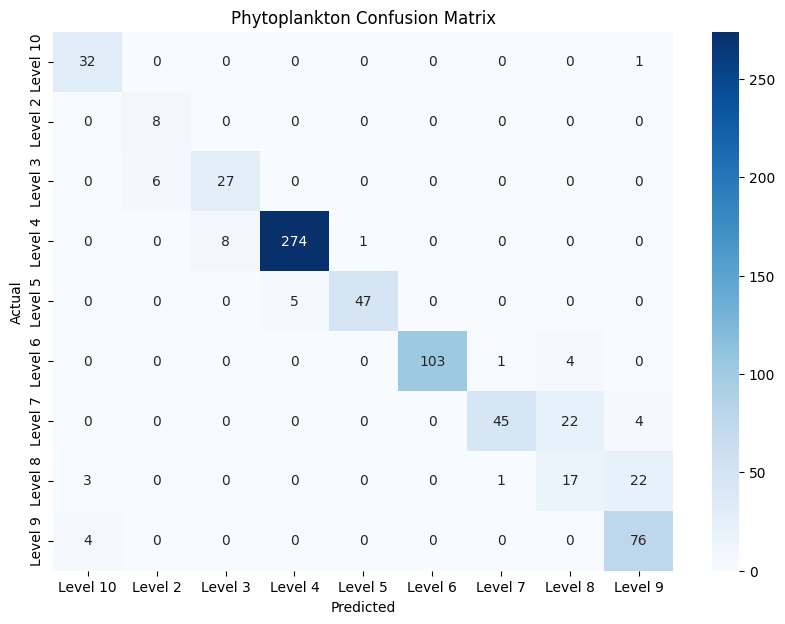

Best parameters for SVM (Zooplankton): {'C': 100, 'kernel': 'rbf'}
Zooplankton Classification Report:
              precision    recall  f1-score   support

    Level 10       1.00      1.00      1.00        12
     Level 2       1.00      1.00      1.00       133
     Level 3       0.97      0.90      0.93        31
     Level 4       0.96      0.90      0.93        77
     Level 5       0.58      0.90      0.70        50
     Level 6       0.87      0.60      0.71        57
     Level 7       0.96      0.83      0.89       164
     Level 8       0.84      0.96      0.90       122
     Level 9       0.97      1.00      0.98        65

    accuracy                           0.90       711
   macro avg       0.90      0.90      0.89       711
weighted avg       0.91      0.90      0.90       711

Zooplankton Accuracy: 0.8987341772151899


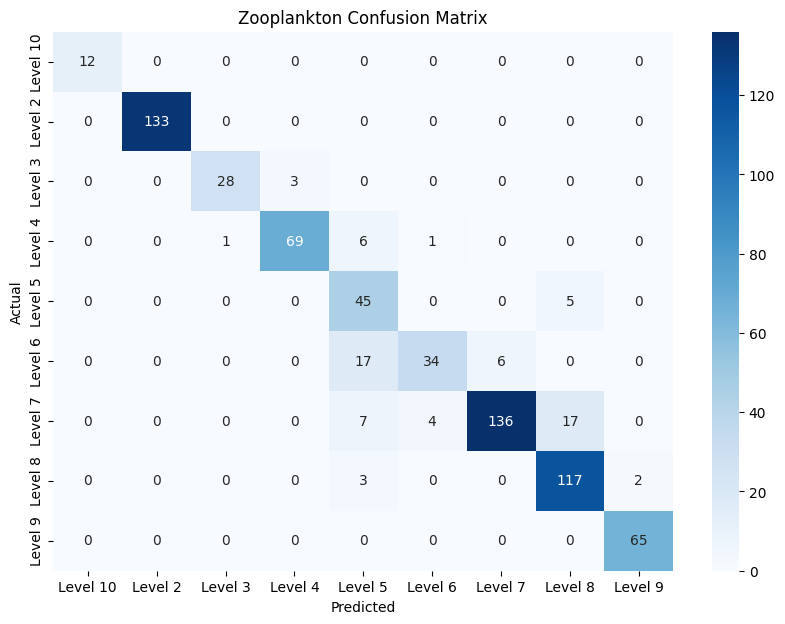

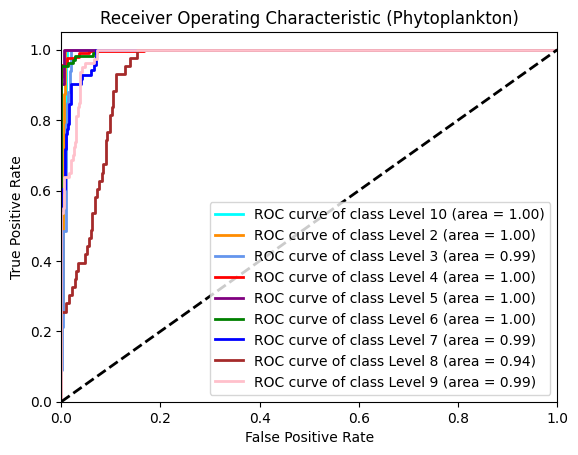

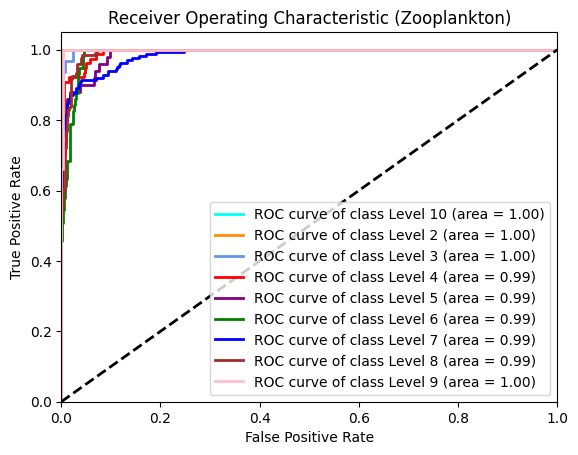

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle

# Load the dataset from the CSV file
df = pd.read_csv('3500leveling.csv')

# Features
X = df[['Temp', 'PH', 'TDS', 'Turbidity', 'DO']]

# Labels
y_phyto = df['Phytoplankton']
y_zoo = df['Zooplankton']

# Encode the labels
le_phyto = LabelEncoder()
le_zoo = LabelEncoder()
y_phyto_encoded = le_phyto.fit_transform(y_phyto)
y_zoo_encoded = le_zoo.fit_transform(y_zoo)

# Binarize the labels for ROC curve
y_phyto_binarized = label_binarize(y_phyto_encoded, classes=range(len(le_phyto.classes_)))
y_zoo_binarized = label_binarize(y_zoo_encoded, classes=range(len(le_zoo.classes_)))

# Split the data into training and testing sets
X_train, X_test, y_phyto_train, y_phyto_test, y_zoo_train, y_zoo_test = train_test_split(
    X, y_phyto_encoded, y_zoo_encoded, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM for Phytoplankton
# Initialize the SVM classifier
svm_phyto = SVC(probability=True, random_state=42)

# Hyperparameter tuning for SVM using GridSearchCV
svm_param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly']}
svm_grid_search_phyto = GridSearchCV(svm_phyto, svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search_phyto.fit(X_train, y_phyto_train)
best_svm_phyto = svm_grid_search_phyto.best_estimator_
print(f"Best parameters for SVM (Phytoplankton): {svm_grid_search_phyto.best_params_}")

# Train the best SVM model on the entire training data
best_svm_phyto.fit(X_train, y_phyto_train)

# Predict and evaluate for Phytoplankton
y_phyto_pred = best_svm_phyto.predict(X_test)
print("Phytoplankton Classification Report:")
print(classification_report(y_phyto_test, y_phyto_pred, target_names=le_phyto.classes_))
print("Phytoplankton Accuracy:", accuracy_score(y_phyto_test, y_phyto_pred))

# Confusion matrix for Phytoplankton
cm_phyto = confusion_matrix(y_phyto_test, y_phyto_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_phyto, annot=True, fmt='d', cmap='Blues', xticklabels=le_phyto.classes_, yticklabels=le_phyto.classes_)
plt.title('Phytoplankton Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SVM for Zooplankton
# Initialize the SVM classifier
svm_zoo = SVC(probability=True, random_state=42)

# Hyperparameter tuning for SVM using GridSearchCV
svm_grid_search_zoo = GridSearchCV(svm_zoo, svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search_zoo.fit(X_train, y_zoo_train)
best_svm_zoo = svm_grid_search_zoo.best_estimator_
print(f"Best parameters for SVM (Zooplankton): {svm_grid_search_zoo.best_params_}")

# Train the best SVM model on the entire training data
best_svm_zoo.fit(X_train, y_zoo_train)

# Predict and evaluate for Zooplankton
y_zoo_pred = best_svm_zoo.predict(X_test)
print("Zooplankton Classification Report:")
print(classification_report(y_zoo_test, y_zoo_pred, target_names=le_zoo.classes_))
print("Zooplankton Accuracy:", accuracy_score(y_zoo_test, y_zoo_pred))

# Confusion matrix for Zooplankton
cm_zoo = confusion_matrix(y_zoo_test, y_zoo_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_zoo, annot=True, fmt='d', cmap='Blues', xticklabels=le_zoo.classes_, yticklabels=le_zoo.classes_)
plt.title('Zooplankton Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Binarize the test labels for ROC curve
y_phyto_test_binarized = label_binarize(y_phyto_test, classes=range(len(le_phyto.classes_)))
y_zoo_test_binarized = label_binarize(y_zoo_test, classes=range(len(le_zoo.classes_)))

# ROC Curve for Phytoplankton
y_phyto_score = best_svm_phyto.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(le_phyto.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_phyto_test_binarized[:, i], y_phyto_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for Phytoplankton
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple', 'green', 'blue', 'brown', 'pink'])
for i, color in zip(range(len(le_phyto.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le_phyto.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Phytoplankton)')
plt.legend(loc="lower right")
plt.show()

# ROC Curve for Zooplankton
y_zoo_score = best_svm_zoo.predict_proba(X_test)

fpr_zoo = dict()
tpr_zoo = dict()
roc_auc_zoo = dict()
for i in range(len(le_zoo.classes_)):
    fpr_zoo[i], tpr_zoo[i], _ = roc_curve(y_zoo_test_binarized[:, i], y_zoo_score[:, i])
    roc_auc_zoo[i] = auc(fpr_zoo[i], tpr_zoo[i])

# Plot ROC curve for Zooplankton
plt.figure()
for i, color in zip(range(len(le_zoo.classes_)), colors):
    plt.plot(fpr_zoo[i], tpr_zoo[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le_zoo.classes_[i], roc_auc_zoo[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Zooplankton)')
plt.legend(loc="lower right")
plt.show()
